<img src="./logo_UNSAM.jpg" align="right" width="250" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº8
#### Nicolás Sewrjugin y Sofía Gervasi


# Introducción

El ciclo cardíaco típico presenta una duración promedio de aproximadamente $600 ms$, durante el cual se manifiestan tres componentes morfológicos fundamentales: la onda *P*, que representa la despolarización auricular; el complejo *QRS*, correspondiente a la despolarización ventricular; y la onda *T*, asociada a la repolarización ventricular. Durante una prueba de esfuerzo, la señal electrocardiográfica se ve particularmente afectada por múltiples fuentes de interferencia que comprometen su calidad. Entre las principales contaminaciones se identifican el ruido de alta frecuencia, originado tanto por el movimiento de los electrodos sobre la superficie cutánea como por la actividad muscular durante el ejercicio, y el desplazamiento de la línea de base en baja frecuencia, inducida principalmente por los movimientos respiratorios.

El objetivo del presente trabajo es diseñar e implementar un conjunto de filtros digitales que permitan eliminar eficazmente estas interferencias preservando al mismo tiempo la morfología característica de la señal. Para ello, se establecerá una plantilla de diseño basada en el ancho de banda típico del *ECG*, se compararán distintas metodologías de diseño de filtros *FIR* e *IIR* y se evaluará el rendimiento de cada filtro tanto en su capacidad de atenuación de interferencias como en su inocuidad sobre la señal de interés.


# Análisis y desarrollo

Para la selección de los métodos de diseño de los filtros digitales para el procesamiento del *ECG* se consideró tanto las características particulares de la señal como las ventajas específicas de cada aproximación. 

Para los filtros *IIR*, se seleccionó el filtro "Butterworth", ya que presenta una respuesta maximalmente plana en la banda de paso, sin ripple, lo que minimiza distorsiones en la amplitud de las componentes espectrales de la senal dentro del ancho de banda de interés. Como segunda alternativa de comparación, se eligió el filtro "Cauer" ya que ofrece la transición más abrupta entre banda de paso y banda de atenuación, para un filtro de derteminado orden, lo que lo hace la opción más eficiente en términos de mínimo orden.

En cuanto a los filtros *FIR*, el método de ventanas permite un controlar mediante la selección del tipo de ventana el compromiso deseado entre ancho de transición y atenuación en la banda rechazada, es una referencia de base ideal para comparar con técnicas más sofisticadas. Por su parte, el método de "Parks-McClellan" proporciona una solución equiripple, que permite especificar el ripple tolerado tanto en banda de paso como en banda de atenuación, lo que nos permite definir plantillas con especificaciones más rigurosas. 

### Plantilla de diseño

In [4]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib.patches as patches

#Filtro digital  usando valores del ECG

fs = 1000 #Hz
wp = [0.8, 35] #frecuencia de corte (Hz)
ws = [0.1, 40] #frecuencia de stop (Hz) arriba de los 35 debe ser la segunda
#queremos q saque toda la frecuencia menor a 1 Hz (0.8)

alpha_p = 1 #atenuación de corte (db), alpha maxima en bp
alpha_s = 40 #atenuación de stop (db), alpha minima en bs

Para definir la plantilla del filtro digital, se partió del análisis espectral del *ECG* hecho en la *TS5*, donde se observó que la mayor parte de la energía útil del registro se concentra mayormente por debajo de aproximadamente $32–33 Hz$. Por este motivo, se fijó una frecuencia superior de paso de $35 Hz$, lo suficientemente alta para preservar por completo el ancho de banda fisiológico del *ECG*, pero lo bastante baja para atenuar el ruido muscular y de movimiento, que aparece principalmente por encima de ese rango. En el extremo inferior, se seleccionó una frecuencia de paso de $0.8 Hz$ con una banda de rechazo que comienza en $0.1 Hz$, de manera de suprimir eficazmente el movimiento de línea de base y las variaciones lentas asociadas a la respiración. Las bandas de transición entre $0.1–0.8 Hz$ y $35–40 Hz$ se eligieron para garantizar una pendiente razonable del filtro y un diseño realizable, mientras que los niveles de ripple y atenuación (1 dB en banda de paso y 40 dB en banda de rechazo) aseguran que la forma del *ECG* se conserve suavizada y con un nivel isoeléctrico estable, cumpliendo con los requisitos planteados.

### Respuestas de filtros IIR 

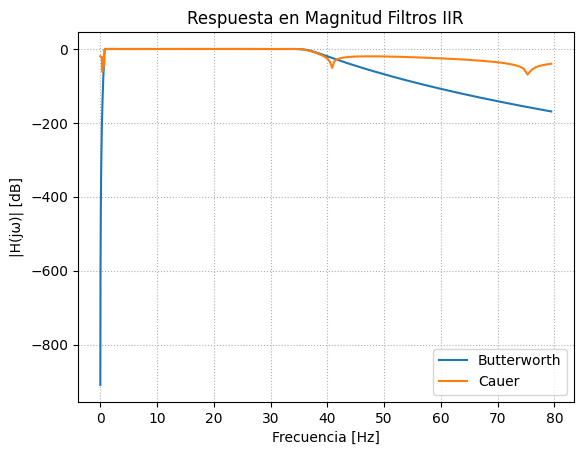

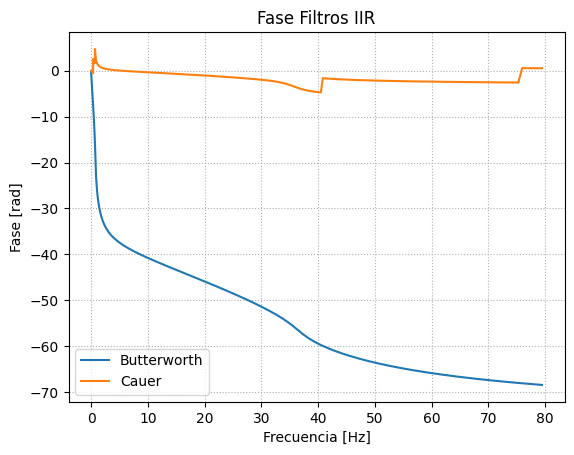

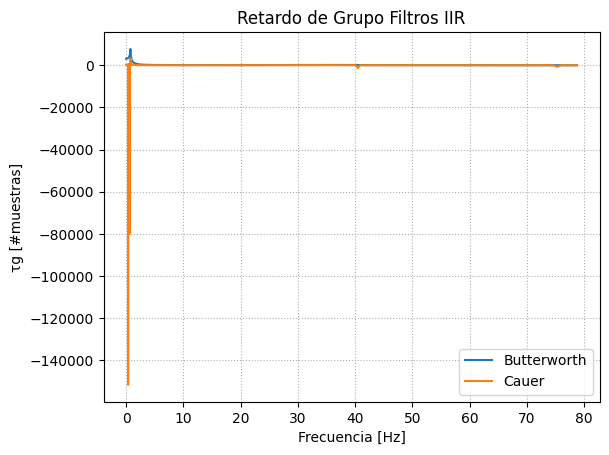

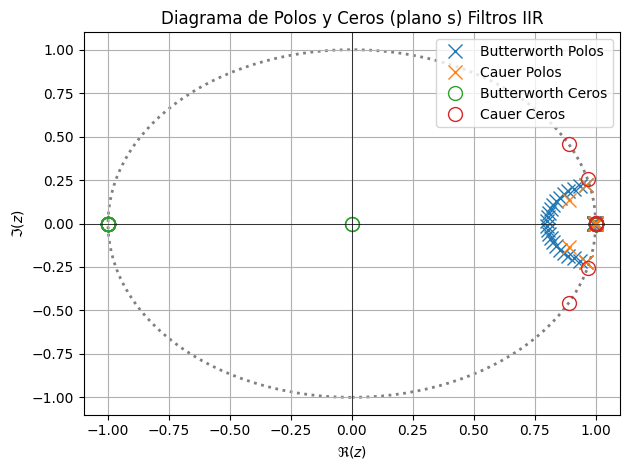

In [5]:
from scipy import signal
#Divido por 2 a los alfas pq con el filtfilt se va al doble de ripple sino (y doble de atenuación que es bueno eso) y asi podemos neutralizar la fase tranquilamente
mi_sos_butt = signal.iirdesign(wp=wp, ws= ws, gpass=alpha_p/2, gstop=alpha_s/2, analog=False, ftype="butter", output='sos', fs = fs)
mi_sos_cauer = signal.iirdesign(wp=wp, ws= ws, gpass=alpha_p/2, gstop=alpha_s/2, analog=False, ftype="cauer", output='sos', fs = fs)

w, h = signal.freqz_sos(mi_sos_butt, worN=np.logspace(-2,1.9,1000), fs = fs)
w2, h2 = signal.freqz_sos(mi_sos_cauer, worN=np.logspace(-2,1.9,1000), fs = fs)

phase = np.unwrap(np.angle(h)) #con unwrap evita la discontinuidad de fase (discontinuidad evitable)
phase2 = np.unwrap(np.angle(h2))

w_rad = w / (fs/2) *np.pi
w_rad2 = w2 / (fs/2) *np.pi

gd = -np.diff(phase)/np.diff(w_rad) #retardo de grupo
gd2 = -np.diff(phase2)/np.diff(w_rad2) 

z, p, k = signal.sos2zpk(mi_sos_butt)
z2, p2, k2 = signal.sos2zpk(mi_sos_cauer)

# Magnitud
plt.figure(1)
plt.plot(w, 20*np.log10(abs(h)), label = 'Butterworth')
plt.plot(w2, 20*np.log10(abs(h2)), label = 'Cauer')
plt.title('Respuesta en Magnitud Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.grid(True, which='both', ls=':')
plt.legend()

# Fase
plt.figure(2)
plt.plot(w, (phase), label = 'Butterworth')
plt.plot(w2, (phase2), label = 'Cauer')
plt.title('Fase Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid(True, which='both', ls=':')
plt.legend()

# Retardo de grupo
plt.figure(3)
plt.plot(w[:-1], gd, label = 'Butterworth')
plt.plot(w2[:-1], gd2, label = 'Cauer')
plt.title('Retardo de Grupo Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('τg [#muestras]')
plt.grid(True, which='both', ls=':')
plt.legend()

# Diagrama de polos y ceros
plt.figure(4)
plt.plot(np.real(p), np.imag(p), 'x', markersize=10, label='Butterworth Polos' )
plt.plot(np.real(p2), np.imag(p2), 'x', markersize=10, label='Cauer Polos' )
axes_hdl = plt.gca()

if len(z) > 0:
    plt.plot(np.real(z), np.imag(z), 'o', markersize=10, fillstyle='none', label='Butterworth Ceros')
    plt.plot(np.real(z2), np.imag(z2), 'o', markersize=10, fillstyle='none', label='Cauer Ceros')
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
unit_circle = patches.Circle((0, 0), radius=1, fill=False,
                             color='gray', ls='dotted', lw=2)
axes_hdl.add_patch(unit_circle)

plt.axis([-1.1, 1.1, -1.1, 1.1])
plt.title('Diagrama de Polos y Ceros (plano s) Filtros IIR')
plt.xlabel(r'$\Re(z)$')
plt.ylabel(r'$\Im(z)$')
plt.legend()
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




### Filtros IIR aplicados al ECG

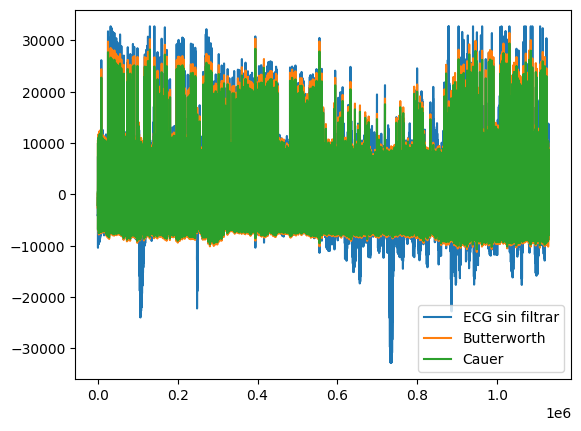

In [7]:
#ECG
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)
cant_muestras = N


ecg_filt_butt = signal.sosfiltfilt(mi_sos_butt, ecg_one_lead)
ecg_filt_cauer = signal.sosfiltfilt(mi_sos_cauer, ecg_one_lead)

plt.figure(5)
plt.plot(ecg_one_lead, label = 'ECG sin filtrar')
plt.plot(ecg_filt_butt, label = 'Butterworth')
plt.plot(ecg_filt_cauer, label = 'Cauer')
plt.legend()

### Respuestas de los filtros FIR

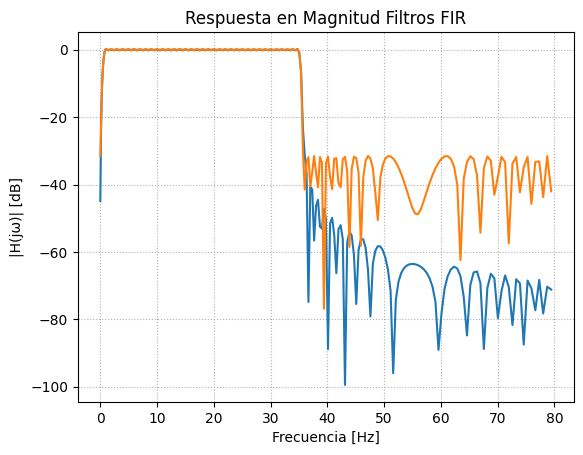

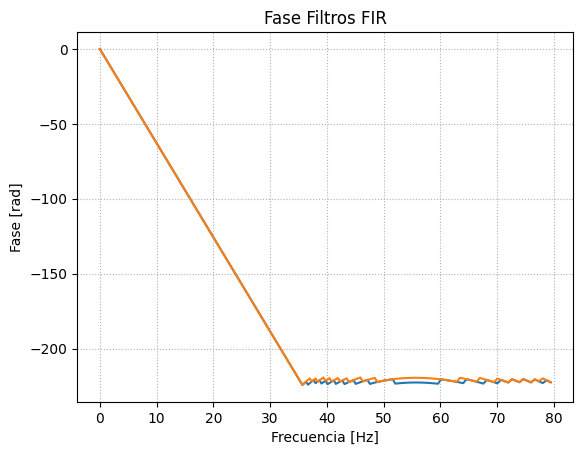

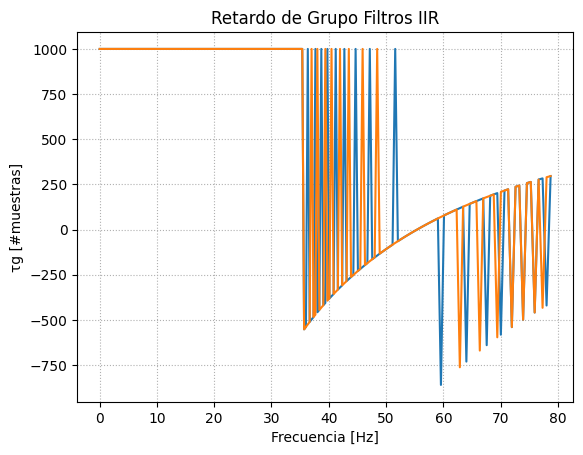

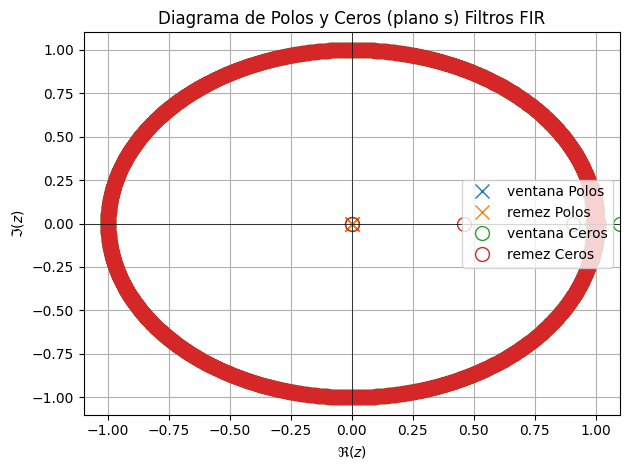

In [9]:
fs = 1000
wp = [0.8, 35] 
ws = [0.1, 35.7] #cambio de 40 a 35.7 para que la transicion sea mas ancha y tenga mas margen para ajustar el filtro

frecuencias = np.sort(np.concatenate(((0,fs/2), wp, ws))) #ordena las freqs de ws y wp en ascendente. Debe empezar en 0 y terminar en fs/2
deseado = [0,0,1,1,0,0] #la rta uno a uno con las frecuencias para que sea pasa banda
cant_coef = 2000 #filtro par. El orden es nuestro unico grado de libertad
retardo = (cant_coef -1)//2

fir_win_rect = signal.firwin2(numtaps=cant_coef, freq=frecuencias, gain=deseado, fs=fs, nfreqs=int((np.ceil(np.sqrt(cant_coef))*2)**2)-1, window='rectangular')

deseado_PM = [0,1,0] #deseado PM debe ser la mitad de las bandas
fir_win_pm = signal.remez(numtaps=cant_coef, bands=frecuencias, desired=deseado_PM, fs=fs)

w3, h3 = signal.freqz(b=fir_win_rect, worN=np.logspace(-2,1.9,1000), fs=fs) #freqz me da solo a0=1, todos los polos en el origen (misma cantidad q los ceros, igual a cant_coef) pq es FIR
w4, h4 = signal.freqz(b=fir_win_pm, worN=np.logspace(-2,1.9,1000), fs=fs)

phase3 = np.unwrap(np.angle(h3)) #con unwrap evita la discontinuidad de fase (discontinuidad evitable)
phase4 = np.unwrap(np.angle(h4))

w_rad3 = w3 / (fs/2) *np.pi
w_rad4 = w4 / (fs/2) *np.pi
gd3 = -np.diff(phase3)/np.diff(w_rad3) #retardo de grupo
gd4 = -np.diff(phase4)/np.diff(w_rad4)

z3, p3, k3 = signal.sos2zpk(signal.tf2sos(b=fir_win_rect, a=1))
z4, p4, k4 = signal.sos2zpk(signal.tf2sos(b=fir_win_pm, a=1))

plt.figure(6)
plt.plot(w3, 20*np.log10(abs(h3)), label = 'ventana')
plt.plot(w4, 20*np.log10(abs(h4)), label = 'remez')
plt.title('Respuesta en Magnitud Filtros FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.grid(True, which='both', ls=':')

# Fase
plt.figure(7)
plt.plot(w3, (phase3), label = 'ventana')
plt.plot(w4, (phase4), label = 'remez')
plt.title('Fase Filtros FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid(True, which='both', ls=':')

# Retardo de grupo
plt.figure(8)
plt.plot(w3[:-1], gd3, label = 'ventana')
plt.plot(w4[:-1], gd4, label = 'remez')
plt.title('Retardo de Grupo Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('τg [#muestras]')
plt.grid(True, which='both', ls=':')

# Diagrama de polos y ceros
plt.figure(9)
plt.plot(np.real(p3), np.imag(p3), 'x', markersize=10, label='ventana Polos' )
plt.plot(np.real(p4), np.imag(p4), 'x', markersize=10, label='remez Polos' )
axes_hdl = plt.gca()

if len(z) > 0:
    plt.plot(np.real(z3), np.imag(z3), 'o', markersize=10, fillstyle='none', label='ventana Ceros')
    plt.plot(np.real(z4), np.imag(z4), 'o', markersize=10, fillstyle='none', label='remez Ceros')
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
unit_circle = patches.Circle((0, 0), radius=1, fill=False,
                             color='gray', ls='dotted', lw=2)
axes_hdl.add_patch(unit_circle)

plt.axis([-1.1, 1.1, -1.1, 1.1])
plt.title('Diagrama de Polos y Ceros (plano s) Filtros FIR')
plt.xlabel(r'$\Re(z)$')
plt.ylabel(r'$\Im(z)$')
plt.legend()
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Filtros FIR aplicados al ECG

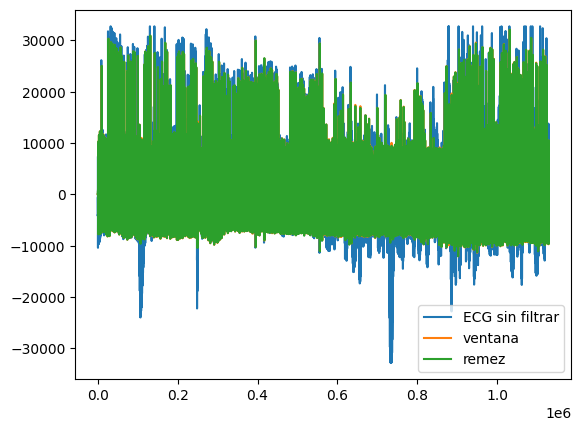

In [10]:
ecg_filt_win = signal.lfilter(b=fir_win_rect, a=1, x=ecg_one_lead)
ecg_filt_remez = signal.lfilter(b=fir_win_pm, a=1, x=ecg_one_lead)

plt.figure(10)
plt.plot(ecg_one_lead, label = 'ECG sin filtrar')
plt.plot(ecg_filt_win, label = 'ventana')
plt.plot(ecg_filt_remez, label = 'remez')
plt.legend()

### Comparaciones de los filtros FIR e IIR

En cuantos a los *FIR*, ambos se implementaron utilizando "iirdesign" en formato *SOS*, empleando atenuaciones de diseño reducidas ($αp/2 y αs/2$) para compensar la duplicación efectiva del ripple introducida por el uso del "filtfilt", lo cual permite mantener fase cero sin comprometer la forma del *ECG*. Las respuestas en magnitud de ambos filtros cumplen los requerimientos: mantienen un piso de al menos 40 dB de atenuación en las bandas prohibidas ($<0.1$ Hz y $>40 Hz$) y una banda de paso bien definida entre $0.8 Hz$ y $35 Hz$. El filtro *Butterworth* muestra una respuesta suave, mientras que el Cauer exhibe transiciones mucho más abruptas.

Para los FIR se diseñaron dos aproximaciones: uno mediante el método de ventanas utilizando "firwin2" con ventana rectangular y otro mediante el algoritmo de "Parks–McClellan–Remez" con "remez". Se utilizó un número elevado de coeficientes (2000) para garantizar transiciones suficientemente angostas sin comprometer la linealidad de fase. Las respuestas en frecuencia muestran que ambos *FIR* cumplen adecuadamente la plantilla: el método de ventanas presenta una transición más suave y mayor ancho de banda de transición, mientras que "Parks–McClellan" logra una caída más limpia y un control más uniforme del ripple. En ambos casos, la fase es estrictamente lineal y el retardo de grupo constante, tal como es característico de los *FIR* de fase lineal.

### Evaluación del rendimiento de los filtros por zonas

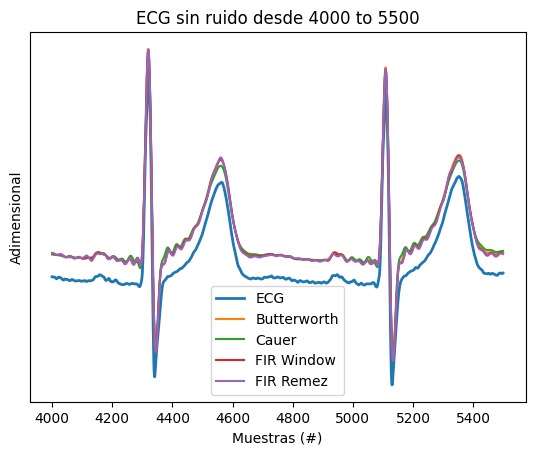

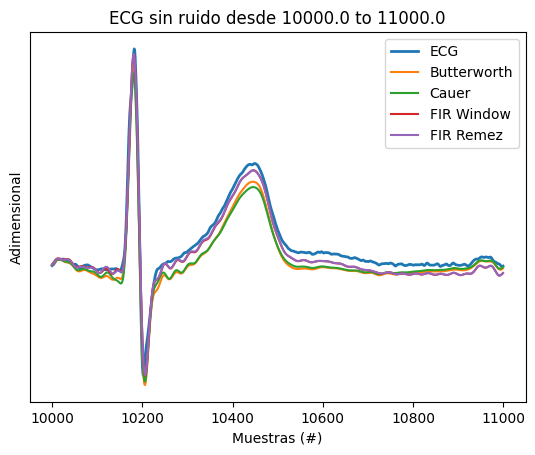

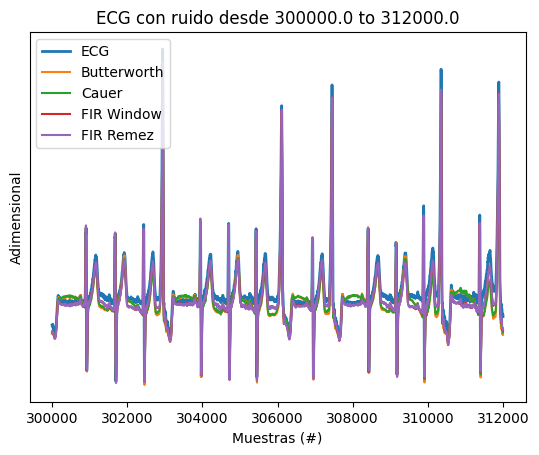

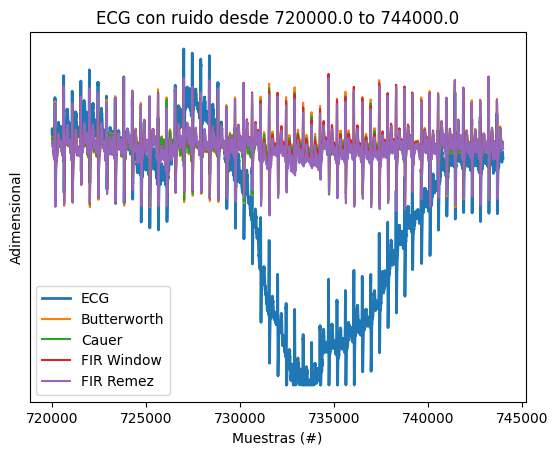

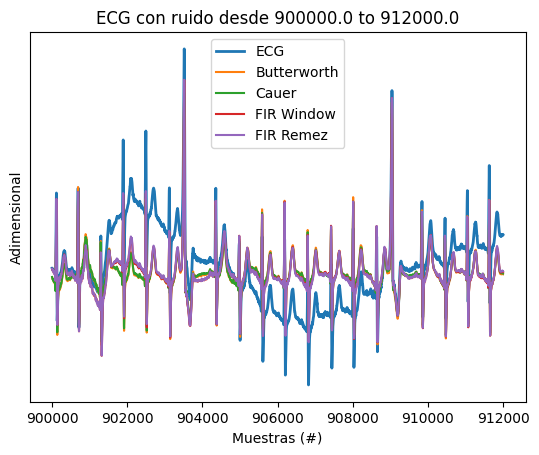

In [11]:
# Regiones de interés sin ruido 
 
regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    plt.plot(zoom_region, ecg_filt_win[zoom_region + retardo], label='FIR Window')
    plt.plot(zoom_region, ecg_filt_remez[zoom_region + retardo], label='FIR Remez')
   
    plt.title('ECG sin ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
# Regiones de interés con ruido 
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    plt.plot(zoom_region, ecg_filt_win[zoom_region + retardo], label='FIR Window')
    plt.plot(zoom_region, ecg_filt_remez[zoom_region + retardo], label='FIR Remez')
   
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

La evaluación del rendimiento de los filtros se realizó analizando regiones del registro del *ECG* con y sin ruido. En las zonas libres de interferencias, se observó que los cuatro filtros ("Butterworth", "Cauer", *FIR* por ventana y *FIR* por "Remez") son inocuos: preservan la forma de las ondas $P, QRS$ y $T$ sin introducir distorsión visible, ni desplazamiento del nivel isoeléctrico. Los *FIR* mostraron un comportamiento prácticamente idéntico a la señal original salvo por el retardo constante introducido, mientras que los *IIR* aplicados con "filtfilt" no presentan retardo de fase, manteniendo la alineación temporal más fiel.

En las zonas con ruido, especialmente aquellas donde se observa movimiento de la línea de base y actividad muscular, todos los filtros lograron atenuar las interferencias esperadas: las oscilaciones lentas ($<0.5 Hz$) desaparecen casi por completo y las componentes de alta frecuencia asociadas a ruido muscular se reducen significativamente. El filtro *Cauer* es el más selectivo, logrando la mayor atenuación del ruido de alta frecuencia, mientras que el Butterworth produce un resultado más suave, pero igualmente efectivo. En el caso de los *FIR*, el diseño con *Remez* muestra mejor rechazo en las bandas prohibidas respecto del *FIR* de ventana, aunque ambos cumplen con los requisitos de limpieza sin deformar el trazo. En síntesis, todos los filtros diseñados cumplen la plantilla establecida para el *ECG* real y demuestran un comportamiento adecuado tanto en regiones limpias como en regiones contaminadas, confirmando la validez del diseño.

# Conclusiones




En conclusión, el estudio realizado permite concluir que la combinación de una plantilla de $0.8–35 Hz$ con bandas de rechazo amplias resulta adecuada para el filtrado de señales *ECG* obtenidas durante una prueba de esfuerzo, donde las interferencias de baja y alta frecuencia suelen ser significativas. Las metodologías *FIR* e *IIR* aplicadas responden bien al diseño: los *IIR* muestran un desempeño eficiente con órdenes reducidos, mientras que los *FIR* garantizan fase lineal y un comportamiento muy predecible. Al analizar múltiples regiones del registro, se observó que en ausencia de ruido los filtros no alteran la morfología de las ondas $P, QRS$ y $T$, lo que confirma su inocuidad. En zonas contaminadas, cada diseño logró eliminar las oscilaciones lentas del nivel de base y reducir de manera efectiva el ruido muscular sin distorsionar la forma del latido. La consistencia entre los distintos métodos respalda la validez de las decisiones adoptadas en el diseño de la plantilla y demuestra que el filtrado recupera con fidelidad la información fisiológica relevante del *ECG*.